
*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  07.11.2023

--- 

# Calculate Cold Start Emissions using HBEFA Emission factors

<!--Notebook description and usage information-->
In this notebook, HBEFA Cold-Start emission factors are applied to input from the visum model. <br>
HBEFA allows to separate cold-start emissions by: 
- Ambient temperature 
- Trip length 
- Parking hours (to determine how hot the engine is before the starting process)

HBEFA provides cold disaggregated cold start emissions where each of the parameters above can be set based on individual data. Since no Munich-specific information on trip lenght or parking hours is available, aggregated values for these categories are used. Temperature information is provided by a weather station in Munich and will be used for the whole region.<br>
It should be mentioned, that HBEFA just provides cold-start emissions for Personal Cars and Small Vans. They conistitue the main part of the overall number of cold starts in a city.


In [119]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

# import custom modules
sys.path.append('../utils')
import calender
import data_paths

from lmu_meteo_api import interface

from datetime import datetime

Loading BokehJS ...

In [120]:

def annual_temperature_profile(year:int,
                               aggregate = 'H') -> pd.Series: 
    assert year <= datetime.now().year
    assert year > 2012
    
    start_time = str(year)+"-01-01T00-00-00"
    end_time = str(year)+"-12-31T23-59-59"
    
    if datetime.strptime(end_time, '%Y-%m-%dT%H-%M-%S').date() > datetime.now().date():
        end_time = datetime.now().strftime('%Y-%m-%dT%H-%M-%S')
    
    lmu_api = interface.meteo_data()
    data = lmu_api.get_meteo_data(parameters = ["air_temperature_2m"], 
                                station_id = 'MIM01', 
                                start_time = start_time, 
                                end_time = end_time)
    
    return (data.air_temperature_2m - 273.15).resample(aggregate).mean()

In [124]:
visum_zones = gpd.read_file(data_paths.VISUM_FOLDER_PATH + "visum_zones.GPKG", driver = 'GPKG')


In [133]:
visum_zones['pkw_start_density'] = visum_zones['qv_pkw']/visum_zones.area
visum_zones['lfw_start_density'] = visum_zones['qv_lkw_k']/visum_zones.area
visum_zones['combined_start_density'] = (visum_zones['qv_lkw_k']+visum_zones['qv_pkw'])/visum_zones.area

<Axes: >

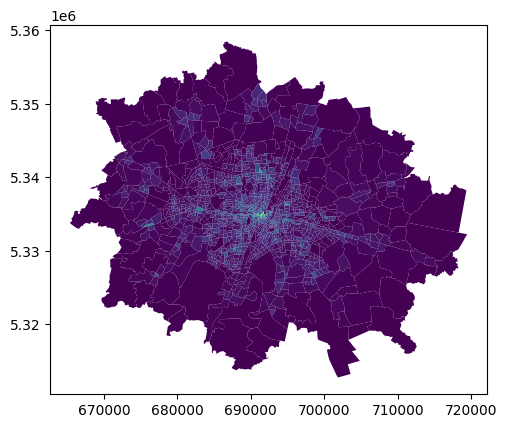

In [134]:
visum_zones.plot(column ='combined_start_density')

<Axes: >

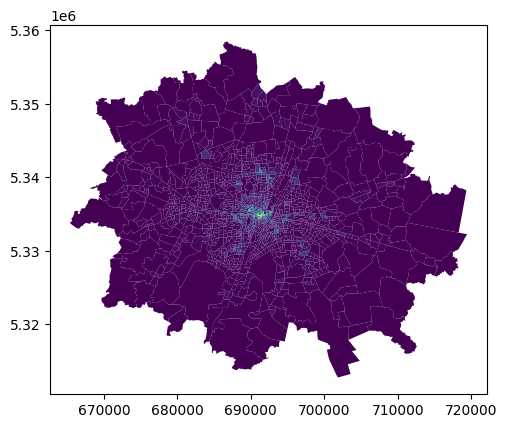

In [132]:
visum_zones.plot(column ='lfw_start_density')

In [116]:
visum_zones

,NO,lkr_name,lkr_nr,gemeinde,s_bezirke,s_bezirkte,s_viertel,qv_pkw,qv_lkw_k,qv_lkw_g,qv_lkw_g_d,qv_lkw_m,qv_lkw_m_d,geometry
0,101110000,"München, Stadt",9162,9162000,1,11,111,821.760,816.460,32.081,0.000,15.690,0.000,"POLYGON ((691754.076 5335024.558, 691738.991 5..."
1,101120000,"München, Stadt",9162,9162000,1,11,112,1271.342,1082.346,27.784,0.000,15.609,0.000,"POLYGON ((691738.353 5335092.229, 691738.991 5..."
2,101131000,"München, Stadt",9162,9162000,1,11,113,263.395,1079.766,29.537,0.000,15.709,0.000,"POLYGON ((692276.321 5334907.600, 692274.227 5..."
3,101132001,"München, Stadt",9162,9162000,1,11,113,532.558,537.905,19.435,0.000,11.328,0.000,"POLYGON ((691926.924 5334982.696, 692026.581 5..."
4,101132002,"München, Stadt",9162,9162000,1,11,113,642.092,521.931,19.829,0.000,9.244,0.000,"POLYGON ((691832.321 5334837.440, 691834.223 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,918812703,None,9188,9188127,99999999,99999999,999999,2176.368,331.232,14.978,31.676,8.685,20.621,"POLYGON ((680165.304 5329164.754, 680097.204 5..."
1504,918812704,None,9188,9188127,99999999,99999999,999999,1756.646,269.778,13.798,33.914,8.072,20.591,"POLYGON ((679008.128 5329774.304, 679007.598 5..."
1505,918812705,None,9188,9188127,99999999,99999999,999999,3134.188,598.513,32.165,105.556,52.929,220.536,"POLYGON ((674455.149 5326697.935, 674434.743 5..."
1506,918813913,None,9188,9188139,99999999,99999999,999999,724.102,90.547,3.398,13.913,2.168,11.890,"POLYGON ((679095.869 5322663.619, 679162.521 5..."
